In [79]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

In [80]:
# Load Credit Cards Data with CFPB Integration
# Step 1: Load credit cards
df_cards = pd.read_csv("creditcards.csv")

# Step 2: Load CFPB data (header is in row 1 of the CSV file)
cfpb = pd.read_csv("cfpb2024.csv", header=0, low_memory=False, encoding='utf-8-sig')

# COMPREHENSIVE MAPPING - Exact product names from CFPB cfpb2024.csv
cfpb_card_map = {
    # American Express Cards (EXACT names from CFPB)
    "Blue Cash Preferred® Card": "Amex_Blue_Cash_Preferred",
    "Blue Cash Everyday® Card": "Amex_Blue_Cash_Everyday",
    "American Express® Gold Card": "Amex_Gold",
    "American Express® Green Card": "Amex_Green",
    "The Platinum Card®": "Amex_Platinum",
    # Note: Amex Business Gold, Cash Magnet, EveryDay cards NOT in CFPB
    
    # Bank of America Cards (EXACT names from CFPB)
    "Bank of America Customized Cash Rewards": "BoA_Customized_Cash",
    "Bank of America Unlimited Cash Rewards": "BoA_Unlimited_Cash",
    "Bank of America Travel Rewards": "BoA_Travel_Rewards",
    "Bank of America Premium Rewards": "BoA_Premium_Rewards",
    
    # Capital One Cards (EXACT names from CFPB)
    "SavorOne Rewards": "Capital1_Savor_Rewards",
    "Savor Rewards": "Capital1_Savor_Rewards",
    "QuicksilverOne Rewards": "QuickSilverOne_Rewards",
    "Quicksilver": "QuickSilverOne_Rewards",
    "VentureOne Rewards": "VentureOne_Rewards",
    "Venture Rewards": "Venture_Rewards",
    
    # Chase Cards (EXACT names from CFPB)
    "Amazon Prime Rewards Visa Card": "Chase_Amazon_Prime_Visa",
    "Amazon Rewards Visa Card": "Chase_Amazon_Prime_Visa",
    "Freedom Flex": "Chase_Freedom_Flex",
    "Freedom Unlimited": "Chase_Freedom_Unlimited",
    "Sapphire Preferred": "Chase_Sapphire_Preferred",
    "Sapphire Reserve": "Chase_Sapphire_Reserve",
    "Ink Business Cash": "Chase_Ink_Business_Cash",
    "Ink Business Preferred": "Chase_Ink_Business_Preferred",
    "Ink Business Unlimited": "Chase_Ink_Business_Unlimited",
    
    # Citi Cards (EXACT names from CFPB - Institution: "Citibank, N.A.")
    "Citi Double Cash": "Citi_Double_Cash",
    "Citi Custom Cash Card": "Citi_Custom_Cash",
    "Costco Anywhere Visa Card by Citi": "Citi_Costco_Visa",
    "Citi AAdvantage Platinum Select World Elite Mastercard": "Citi_AAdvantage_Platinum",
    "Citi Rewards Plus": "Citi_Rewards_Plus",
    "Citi Strata Premier": "Citi_Strata_Premier",
}

# Map CFPB product names to our card names
cfpb['card_name'] = cfpb['Product Name'].map(cfpb_card_map)
cfpb_features = cfpb[['card_name', 'Annual Fee', 'Targeted Credit Tiers', 'Late Fee ($)']].dropna(subset=['card_name'])

# Extract annual fee as numeric
cfpb_features['Annual_Fee'] = pd.to_numeric(cfpb_features['Annual Fee'].replace('[\$,]', '', regex=True), errors='coerce').fillna(0)

# Extract late fee as numeric
cfpb_features['Late_Fee'] = pd.to_numeric(cfpb_features['Late Fee ($)'].replace('[\$,]', '', regex=True), errors='coerce').fillna(0)

# Credit tier
cfpb_features['Credit_Tier_Required'] = cfpb_features['Targeted Credit Tiers'].fillna('No credit score')

# Keep one row per card
cfpb_features = cfpb_features.groupby('card_name').first().reset_index()

# Merge CFPB data with cards
df_cards = df_cards.merge(cfpb_features[['card_name', 'Annual_Fee', 'Late_Fee', 'Credit_Tier_Required']], 
                          on='card_name', how='left')

# Fill missing values with defaults
df_cards['Annual_Fee'] = df_cards['Annual_Fee'].fillna(0)
df_cards['Late_Fee'] = df_cards['Late_Fee'].fillna(30)
df_cards['Credit_Tier_Required'] = df_cards['Credit_Tier_Required'].fillna('No credit score')

print("✓ Cards loaded:", df_cards.shape)
print(f"✓ CFPB data mapped for {len(cfpb_features)} cards")
print("\nCards with CFPB data:")
for idx, row in cfpb_features.iterrows():
    print(f"  • {row['card_name']}: ${row['Annual_Fee']:.0f} annual fee")

# Generate User Data
def generate_user_data(n_users=1000):
    np.random.seed(42)
    df_users = pd.DataFrame({
        "User_ID": range(1, n_users + 1),
        # monthly spends: tune means/stds as needed
        "Spend_Travel": np.random.normal(200, 120, n_users).clip(0),
        "Spend_Dining": np.random.normal(300, 150, n_users).clip(0),
        "Spend_Groceries": np.random.normal(400, 180, n_users).clip(0),
        "Spend_Online": np.random.normal(250, 130, n_users).clip(0),
        "Spend_Other": np.random.normal(350, 200, n_users).clip(0),
        "Credit_Score": np.random.randint(650, 800, n_users),
        # proportion of balance revolved (0 = always PIF, 1 = fully revolving)
        "Revolve_Rate": np.random.beta(2, 8, n_users),  # mostly low but >0
    })
    return df_users

df_users = generate_user_data()
print("\n✓ Users generated:", df_users.shape)

✓ Cards loaded: (72, 19)
✓ CFPB data mapped for 20 cards

Cards with CFPB data:
  • Amex_Platinum: $695 annual fee
  • BoA_Customized_Cash: $0 annual fee
  • BoA_Premium_Rewards: $95 annual fee
  • BoA_Travel_Rewards: $0 annual fee
  • BoA_Unlimited_Cash: $0 annual fee
  • Capital1_Savor_Rewards: $0 annual fee
  • Chase_Amazon_Prime_Visa: $0 annual fee
  • Chase_Freedom_Flex: $0 annual fee
  • Chase_Freedom_Unlimited: $0 annual fee
  • Chase_Sapphire_Preferred: $95 annual fee
  • Chase_Sapphire_Reserve: $550 annual fee
  • Citi_AAdvantage_Platinum: $99 annual fee
  • Citi_Costco_Visa: $0 annual fee
  • Citi_Custom_Cash: $0 annual fee
  • Citi_Double_Cash: $0 annual fee
  • Citi_Rewards_Plus: $0 annual fee
  • Citi_Strata_Premier: $95 annual fee
  • QuickSilverOne_Rewards: $39 annual fee
  • VentureOne_Rewards: $0 annual fee
  • Venture_Rewards: $95 annual fee

✓ Users generated: (1000, 8)


In [81]:
# Join Users Data and Cards Data.
# Create a temporary Key column just for merging these two dataset together and then drop it.
df_users["key"] = 1
df_cards["key"] = 1
df_uc = df_users.merge(df_cards, on="key").drop(columns=["key"])
print("User-Card pairs:", df_uc.shape)

User-Card pairs: (72000, 27)


In [82]:
# Feature Engineering on User Data
# Our goal is to evaluate which credit card most suite the user's need based on their spending habit

def calculate_card_rewards(row):
    total_rewards = 0

    # Map spending columns to generic category names
    spend_categories = {
        "Travel": row["Spend_Travel"],
        "Dining": row["Spend_Dining"],
        "Groceries": row["Spend_Groceries"],
        "Online_Shopping": row["Spend_Online"], # Assuming 'Online' maps to 'Online_Shopping'
        "Other": row["Spend_Other"],
    }

    card_name = row["card_name"]
    choice_category = row["choice_category"]
    base_rate = row["base_rate"]
    grocery_rate = row["grocery_rate"]
    choice_rate = row["choice_rate"]
    quarterly_cap = row["quarterly_cap"]
    post_cap_rate = row["post_cap_rate"]

    # Iterate through each spending category to calculate rewards
    for category_name, spend_amount in spend_categories.items():
        # Determine the primary effective rate for the current category
        effective_rate = base_rate
        if category_name == choice_category:
            effective_rate = choice_rate
        elif category_name == "Groceries":
            effective_rate = grocery_rate

        # Determine cap parameters for the current category
        monthly_cap_amount = float('inf') # Default to no cap (effectively infinite)
        rate_after_cap = effective_rate   # Default to same rate after cap

        # If it's the chosen category and a quarterly cap exists, apply specific cap logic
        if category_name == choice_category and quarterly_cap > 0:
            monthly_cap_amount = quarterly_cap / 3.0 # Convert quarterly cap to monthly cap
            rate_after_cap = post_cap_rate

        # Calculate rewards considering the cap
        rewards_up_to_cap = min(spend_amount, monthly_cap_amount) * effective_rate
        rewards_over_cap = max(0, spend_amount - monthly_cap_amount) * rate_after_cap
        current_category_rewards = rewards_up_to_cap + rewards_over_cap

        total_rewards += current_category_rewards

    return total_rewards


  # 2. Factor to be added: Credit history, what are some factors that you will draw your data
  # In presentation: Make it a story -> Prove it with evaluation -> What trends you see -> Draw difference
  # People should be able to understand in simple

  # 3. How would they maximize if they miss some points
  # Guiding them to see customer did -> trend -> how they can optimize their spending
  # Format: Based the output, we create the response, decide a common table, draw a common table
  # Your conclusion with different points: For what category, anything random, what would have been better if this was done
  # What would have been better by doing X and Y

In [83]:
# Calculating monthly/annual card rewards for each user
df_uc["Monthly_Rewards"] = df_uc.apply(calculate_card_rewards, axis=1)
df_uc["Annual_Rewards"] = df_uc["Monthly_Rewards"] * 12

# Subtract annual fees from rewards (important pricing factor!)
df_uc["Net_Annual_Value"] = df_uc["Annual_Rewards"] - df_uc["Annual_Fee"]

print(f"Sample net values after fees:")
print(df_uc[['card_name', 'Annual_Rewards', 'Annual_Fee', 'Net_Annual_Value']].head(10))

Sample net values after fees:
             card_name  Annual_Rewards  Annual_Fee  Net_Annual_Value
0  BoA_Customized_Cash      180.687736         0.0        180.687736
1  BoA_Customized_Cash      181.164140         0.0        181.164140
2  BoA_Customized_Cash      303.064531         0.0        303.064531
3  BoA_Customized_Cash      242.993103         0.0        242.993103
4  BoA_Customized_Cash      180.687736         0.0        180.687736
5  BoA_Customized_Cash      180.687736         0.0        180.687736
6   BoA_Unlimited_Cash      220.907380         0.0        220.907380
7   BoA_Travel_Rewards      220.907380         0.0        220.907380
8   BoA_Travel_Rewards      220.907380         0.0        220.907380
9  BoA_Premium_Rewards      220.907380        95.0        125.907380


In [84]:
# Find the BEST card for each user based on NET value (rewards - annual fee)
idx_best_card = df_uc.groupby("User_ID")["Net_Annual_Value"].idxmax()
df_best_cards = df_uc.loc[idx_best_card, ["User_ID", "card_name", "Annual_Rewards", "Annual_Fee", "Net_Annual_Value",
                                            "Spend_Travel", "Spend_Dining", "Spend_Groceries",
                                            "Spend_Online", "Spend_Other", "Credit_Score"]].copy()

# Create credit score tier for categorical feature
def credit_score_tier(score):
    if score >= 750:
        return 3  # Excellent
    elif score >= 700:
        return 2  # Good
    elif score >= 650:
        return 1  # Fair
    else:
        return 0  # Poor

df_best_cards["Credit_Tier"] = df_best_cards["Credit_Score"].apply(credit_score_tier)

print(f"\nBest card identified for each of {len(df_best_cards)} users")
print(f"\nCard distribution (now considers annual fees):")
print(df_best_cards["card_name"].value_counts())
print(f"\nSample with fees impact:")
print(df_best_cards[['card_name', 'Annual_Rewards', 'Annual_Fee', 'Net_Annual_Value']].head(10))


Best card identified for each of 1000 users

Card distribution (now considers annual fees):
card_name
Amex_Blue_Cash_Preferred    712
Citi_Double_Cash            232
Capital1_Savor_Rewards       52
BoA_Customized_Cash           4
Name: count, dtype: int64

Sample with fees impact:
                    card_name  Annual_Rewards  Annual_Fee  Net_Annual_Value
13     Capital1_Savor_Rewards      336.480681         0.0        336.480681
116  Amex_Blue_Cash_Preferred      401.751891         0.0        401.751891
206          Citi_Double_Cash      334.527900         0.0        334.527900
278          Citi_Double_Cash      448.851709         0.0        448.851709
350          Citi_Double_Cash      248.343525         0.0        248.343525
404  Amex_Blue_Cash_Preferred      444.742131         0.0        444.742131
476  Amex_Blue_Cash_Preferred      424.592538         0.0        424.592538
517    Capital1_Savor_Rewards      301.147823         0.0        301.147823
620  Amex_Blue_Cash_Preferred    

In [85]:
# VERIFICATION: Check CFPB Mapping Success
print("="*70)
print("CFPB DATA MAPPING VERIFICATION")
print("="*70)

# Cards in your creditcards.csv
cards_in_system = df_cards['card_name'].unique()
print(f"\nTotal cards in creditcards.csv: {len(cards_in_system)}")

# Cards that got CFPB data (non-zero annual fee or non-default late fee)
cards_with_cfpb = df_cards[(df_cards['Annual_Fee'] > 0) | (df_cards['Late_Fee'] != 30)]['card_name'].unique()
print(f"\n✓ Cards WITH CFPB data ({len(cards_with_cfpb)}):")
for card in sorted(cards_with_cfpb):
    sample = df_cards[df_cards['card_name']==card].iloc[0]
    print(f"  • {card}: Annual Fee=${sample['Annual_Fee']:.0f}, Late Fee=${sample['Late_Fee']:.0f}")

# Cards missing CFPB data
cards_without_cfpb = df_cards[(df_cards['Annual_Fee'] == 0) & (df_cards['Late_Fee'] == 30)]['card_name'].unique()
print(f"\n✗ Cards WITHOUT CFPB data (using defaults) ({len(cards_without_cfpb)}):")
for card in sorted(cards_without_cfpb):
    print(f"  • {card}")

print("\n" + "="*70)
print(f"MAPPING SUCCESS: {len(cards_with_cfpb)}/{len(cards_in_system)} cards ({len(cards_with_cfpb)/len(cards_in_system)*100:.1f}%)")
print("="*70)
print("\n✓ Model now uses: Spending (5 categories) + Credit Score + Annual Fees")
print("="*70)

CFPB DATA MAPPING VERIFICATION

Total cards in creditcards.csv: 31

✓ Cards WITH CFPB data (20):
  • Amex_Platinum: Annual Fee=$695, Late Fee=$29
  • BoA_Customized_Cash: Annual Fee=$0, Late Fee=$29
  • BoA_Premium_Rewards: Annual Fee=$95, Late Fee=$29
  • BoA_Travel_Rewards: Annual Fee=$0, Late Fee=$29
  • BoA_Unlimited_Cash: Annual Fee=$0, Late Fee=$29
  • Capital1_Savor_Rewards: Annual Fee=$0, Late Fee=$29
  • Chase_Amazon_Prime_Visa: Annual Fee=$0, Late Fee=$28
  • Chase_Freedom_Flex: Annual Fee=$0, Late Fee=$29
  • Chase_Freedom_Unlimited: Annual Fee=$0, Late Fee=$29
  • Chase_Sapphire_Preferred: Annual Fee=$95, Late Fee=$29
  • Chase_Sapphire_Reserve: Annual Fee=$550, Late Fee=$29
  • Citi_AAdvantage_Platinum: Annual Fee=$99, Late Fee=$41
  • Citi_Costco_Visa: Annual Fee=$0, Late Fee=$41
  • Citi_Custom_Cash: Annual Fee=$0, Late Fee=$41
  • Citi_Double_Cash: Annual Fee=$0, Late Fee=$41
  • Citi_Rewards_Plus: Annual Fee=$0, Late Fee=$41
  • Citi_Strata_Premier: Annual Fee=$95, Lat

In [86]:
# X = Spending Habits + Credit Score (CFPB data integrated!)
feature_columns = ['Spend_Travel', 'Spend_Dining', 'Spend_Groceries', 'Spend_Online', 'Spend_Other', 'Credit_Score', 'Credit_Tier']
X = df_best_cards[feature_columns].values
y = df_best_cards['card_name'].values

print(f"Features being used: {feature_columns}")
print(f"Training data shape: {X.shape}")

# Scale the features to help with model convergence
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Setup stratified k-fold cross-validation
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Create the model
model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Evaluate model using cross-validation on training data
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
print("Cross-Validation Accuracy for each fold:", scores)
average_cv_accuracy = np.mean(scores)
print(f"Average Cross-Validation Accuracy: {average_cv_accuracy:.4f}")

# Fit the final model on all training data
model.fit(X_train, y_train)
print("\nModel trained on full training set")

Features being used: ['Spend_Travel', 'Spend_Dining', 'Spend_Groceries', 'Spend_Online', 'Spend_Other', 'Credit_Score', 'Credit_Tier']
Training data shape: (1000, 7)
Cross-Validation Accuracy for each fold: [0.825  0.8625 0.875  0.8375 0.825 ]
Average Cross-Validation Accuracy: 0.8450

Model trained on full training set


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Test Set Accuracy: 0.8650

CLASS DISTRIBUTION ANALYSIS

Training set distribution:
Amex_Blue_Cash_Preferred    574
Citi_Double_Cash            174
Capital1_Savor_Rewards       48
BoA_Customized_Cash           4
Name: count, dtype: int64

Test set distribution:
Amex_Blue_Cash_Preferred    138
Citi_Double_Cash             58
Capital1_Savor_Rewards        4
Name: count, dtype: int64

Baseline (always predict 'Amex_Blue_Cash_Preferred'): 0.6900
Model improvement over baseline: +17.50%

CONFUSION MATRIX


<Figure size 1200x1000 with 0 Axes>

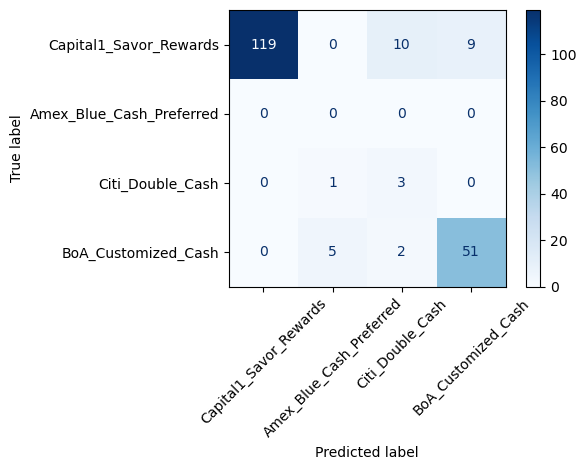

<Figure size 1200x1000 with 0 Axes>

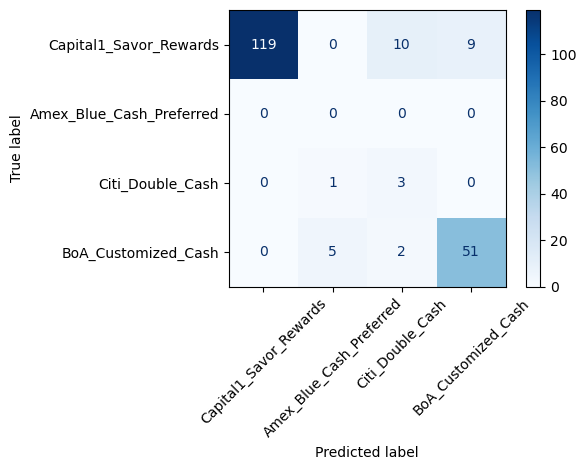

In [87]:
# Making predictions on test set
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Check class distribution in train and test sets
print(f"\n{'='*60}")
print("CLASS DISTRIBUTION ANALYSIS")
print(f"{'='*60}")
print("\nTraining set distribution:")
train_dist = pd.Series(y_train).value_counts()
print(train_dist)
print(f"\nTest set distribution:")
test_dist = pd.Series(y_test).value_counts()
print(test_dist)

# Baseline accuracy (always predict majority class)
majority_class = train_dist.idxmax()
baseline_accuracy = (y_test == majority_class).mean()
print(f"\nBaseline (always predict '{majority_class}'): {baseline_accuracy:.4f}")
print(f"Model improvement over baseline: +{(test_accuracy - baseline_accuracy)*100:.2f}%")

# Display the Confusion Matrix with better formatting
print(f"\n{'='*60}")
print("CONFUSION MATRIX")
print(f"{'='*60}")

# Create a larger figure for better visibility
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=df_best_cards["card_name"].unique())
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.tight_layout()

# Displays the Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=df_best_cards["card_name"].unique())
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.tight_layout()

In [88]:
# CREDIT MAXIMIZATION INSIGHTS - How Users Can Maximize Their Rewards
print("="*80)
print("CREDIT CARD OPTIMIZATION INSIGHTS")
print("How to Maximize Your Credit Card Rewards")
print("="*80)

# Analyze spending patterns and provide recommendations
sample_user = df_best_cards.iloc[0].copy()
user_id = sample_user['User_ID']

print(f"\n📊 ANALYSIS FOR USER {user_id}")
print("="*80)

# Get all cards for this user
user_cards = df_uc[df_uc['User_ID'] == user_id].copy()
user_cards = user_cards.sort_values('Net_Annual_Value', ascending=False)

# Best card
best_card = user_cards.iloc[0]
best_rewards = best_card['Annual_Rewards']
best_fee = best_card['Annual_Fee']
best_net = best_card['Net_Annual_Value']

print(f"\n✅ RECOMMENDED CARD: {best_card['card_name']}")
print(f"   • Annual Rewards: ${best_rewards:.2f}")
print(f"   • Annual Fee: ${best_fee:.2f}")
print(f"   • Net Annual Value: ${best_net:.2f}")

# Show top 3 alternatives
print(f"\n📋 TOP 3 CARD OPTIONS:")
for idx in range(min(3, len(user_cards))):
    card = user_cards.iloc[idx]
    print(f"\n   {idx+1}. {card['card_name']}")
    print(f"      • Annual Rewards: ${card['Annual_Rewards']:.2f}")
    print(f"      • Annual Fee: ${card['Annual_Fee']:.2f}")
    print(f"      • Net Value: ${card['Net_Annual_Value']:.2f}")
    if idx == 0:
        print(f"      ⭐ BEST CHOICE")
    else:
        gap = best_net - card['Net_Annual_Value']
        print(f"      💰 You'd miss ${gap:.2f}/year vs. best card")

# Spending analysis
print(f"\n💳 SPENDING PATTERN ANALYSIS:")
print("="*80)
total_spend = (sample_user['Spend_Travel'] + sample_user['Spend_Dining'] + 
               sample_user['Spend_Groceries'] + sample_user['Spend_Online'] + 
               sample_user['Spend_Other']) * 12

spending_breakdown = {
    'Travel': sample_user['Spend_Travel'] * 12,
    'Dining': sample_user['Spend_Dining'] * 12,
    'Groceries': sample_user['Spend_Groceries'] * 12,
    'Online Shopping': sample_user['Spend_Online'] * 12,
    'Other': sample_user['Spend_Other'] * 12
}

print(f"\nAnnual Spending: ${total_spend:,.2f}")
for category, amount in sorted(spending_breakdown.items(), key=lambda x: x[1], reverse=True):
    pct = (amount / total_spend) * 100
    print(f"   • {category}: ${amount:,.2f} ({pct:.1f}%)")

# Optimization recommendations
print(f"\n🎯 OPTIMIZATION RECOMMENDATIONS:")
print("="*80)

# Find highest spending category
top_category = max(spending_breakdown.items(), key=lambda x: x[1])

# Check if user is maximizing that category
best_card_category = best_card['choice_category']
print(f"\n1. SPENDING ALIGNMENT:")
print(f"   • Your highest spending: {top_category[0]} (${top_category[1]:,.2f}/year)")
print(f"   • Best card optimizes: {best_card_category}")
if top_category[0].lower() in best_card_category.lower():
    print(f"   ✅ Excellent! Your card matches your highest spending category")
else:
    print(f"   ⚠️  Consider a card that rewards {top_category[0]} spending more")

# Credit score insights
print(f"\n2. CREDIT SCORE IMPACT:")
credit_score = sample_user['Credit_Score']
credit_tier = sample_user['Credit_Tier']
print(f"   • Your Credit Score: {credit_score}")
print(f"   • Credit Tier: {'Excellent' if credit_tier == 3 else 'Good' if credit_tier == 2 else 'Fair' if credit_tier == 1 else 'Poor'}")

if credit_tier >= 2:
    print(f"   ✅ Great score! You qualify for premium cards with higher rewards")
    print(f"   💡 Consider cards with annual fees if rewards > fees")
else:
    print(f"   💡 Focus on building credit to access better reward cards")

# Annual fee analysis
print(f"\n3. ANNUAL FEE ANALYSIS:")
if best_fee > 0:
    roi = (best_net / best_fee) if best_fee > 0 else float('inf')
    print(f"   • Annual Fee: ${best_fee:.2f}")
    print(f"   • Return on Fee: {roi:.1f}x (${best_net:.2f} net value)")
    if roi > 10:
        print(f"   ✅ Excellent ROI! The fee is well worth it")
    elif roi > 3:
        print(f"   ✅ Good ROI, the card pays for itself")
    else:
        print(f"   ⚠️  Consider if the fee is worth it for your spending level")
else:
    print(f"   • No Annual Fee")
    print(f"   ✅ Perfect for maximizing net rewards!")

# Opportunity cost
print(f"\n4. MAXIMIZATION OPPORTUNITIES:")
second_best = user_cards.iloc[1] if len(user_cards) > 1 else None
if second_best is not None:
    opportunity = best_net - second_best['Net_Annual_Value']
    print(f"   • You're maximizing by ${opportunity:.2f} vs. 2nd best option")
    
    # Check if multi-card strategy would help
    if opportunity < 50 and total_spend > 15000:
        print(f"   💡 CONSIDER A MULTI-CARD STRATEGY:")
        print(f"      • Use different cards for different categories")
        print(f"      • Potential to earn ${total_spend * 0.02:.2f}+ more/year")

# Spending optimization tips
print(f"\n5. SPENDING OPTIMIZATION TIPS:")
if spending_breakdown['Travel'] > 3000:
    print(f"   ✈️  High Travel Spending (${spending_breakdown['Travel']:,.2f}):")
    print(f"      • Look for cards with travel-specific rewards")
    print(f"      • Consider transferable points (Amex, Chase Ultimate Rewards)")

if spending_breakdown['Dining'] > 3000:
    print(f"   🍽️  High Dining Spending (${spending_breakdown['Dining']:,.2f}):")
    print(f"      • Maximize with dining-focused cards (3-4% cashback)")
    print(f"      • Use dining portals for additional rewards")

if spending_breakdown['Groceries'] > 3000:
    print(f"   🛒 High Grocery Spending (${spending_breakdown['Groceries']:,.2f}):")
    print(f"      • Cards like Amex Blue Cash Preferred (6% on groceries)")
    print(f"      • Watch for quarterly caps - maximize first $1,500/quarter")

if spending_breakdown['Online Shopping'] > 3000:
    print(f"   🛍️  High Online Spending (${spending_breakdown['Online Shopping']:,.2f}):")
    print(f"      • Use shopping portals for additional rewards")
    print(f"      • Consider cards with online shopping bonus categories")

print(f"\n6. NEXT STEPS TO MAXIMIZE:")
print(f"   📱 Set up category tracking to optimize spending")
print(f"   🔄 Review card choice quarterly as spending patterns change")
print(f"   💰 Always pay balance in full to avoid interest fees")
print(f"   🎁 Look for signup bonuses when opening new cards")

print("\n" + "="*80)
print("💡 REMEMBER: The best card is the one you'll actually use consistently!")
print("="*80)


CREDIT CARD OPTIMIZATION INSIGHTS
How to Maximize Your Credit Card Rewards

📊 ANALYSIS FOR USER 1

✅ RECOMMENDED CARD: Capital1_Savor_Rewards
   • Annual Rewards: $336.48
   • Annual Fee: $0.00
   • Net Annual Value: $336.48

📋 TOP 3 CARD OPTIONS:

   1. Capital1_Savor_Rewards
      • Annual Rewards: $336.48
      • Annual Fee: $0.00
      • Net Value: $336.48
      ⭐ BEST CHOICE

   2. Amex_Blue_Cash_Preferred
      • Annual Rewards: $314.35
      • Annual Fee: $0.00
      • Net Value: $314.35
      💰 You'd miss $22.13/year vs. best card

   3. Amex_Blue_Cash_Preferred
      • Annual Rewards: $314.35
      • Annual Fee: $0.00
      • Net Value: $314.35
      💰 You'd miss $22.13/year vs. best card

💳 SPENDING PATTERN ANALYSIS:

Annual Spending: $14,727.16
   • Dining: $6,118.84 (41.5%)
   • Groceries: $3,341.61 (22.7%)
   • Travel: $3,115.27 (21.2%)
   • Other: $2,127.62 (14.4%)
   • Online Shopping: $23.82 (0.2%)

🎯 OPTIMIZATION RECOMMENDATIONS:

1. SPENDING ALIGNMENT:
   • Your highe

In [89]:
# FUNCTION: Get Personalized Credit Maximization Analysis for Any User
def analyze_user_optimization(user_id, show_top_n=5):
    """
    Provides detailed credit card optimization insights for a specific user.
    
    Parameters:
    - user_id: The User_ID to analyze
    - show_top_n: Number of top card options to show (default: 5)
    """
    print("="*80)
    print(f"PERSONALIZED CREDIT OPTIMIZATION REPORT")
    print(f"User ID: {user_id}")
    print("="*80)
    
    # Get user data
    user_row = df_best_cards[df_best_cards['User_ID'] == user_id]
    if len(user_row) == 0:
        print(f"❌ User {user_id} not found!")
        return
    
    user_data = user_row.iloc[0]
    
    # Get all card options for this user
    user_cards = df_uc[df_uc['User_ID'] == user_id].copy()
    user_cards = user_cards.sort_values('Net_Annual_Value', ascending=False)
    
    # Current best card
    best = user_cards.iloc[0]
    
    # Spending breakdown
    monthly_spend = {
        'Travel': user_data['Spend_Travel'],
        'Dining': user_data['Spend_Dining'],
        'Groceries': user_data['Spend_Groceries'],
        'Online': user_data['Spend_Online'],
        'Other': user_data['Spend_Other']
    }
    
    annual_spend = {k: v * 12 for k, v in monthly_spend.items()}
    total_annual = sum(annual_spend.values())
    
    print(f"\n📊 YOUR SPENDING PROFILE:")
    print("-"*80)
    print(f"Total Annual Spending: ${total_annual:,.2f}")
    for category, amount in sorted(annual_spend.items(), key=lambda x: x[1], reverse=True):
        pct = (amount / total_annual) * 100
        print(f"   • {category:15} ${amount:>8,.2f} ({pct:>5.1f}%)")
    
    print(f"\n💳 TOP {show_top_n} CARD RECOMMENDATIONS:")
    print("-"*80)
    for idx in range(min(show_top_n, len(user_cards))):
        card = user_cards.iloc[idx]
        gap = best['Net_Annual_Value'] - card['Net_Annual_Value']
        
        print(f"\n{idx+1}. {card['card_name']}")
        print(f"   Annual Rewards:  ${card['Annual_Rewards']:>7,.2f}")
        print(f"   Annual Fee:      ${card['Annual_Fee']:>7,.2f}")
        print(f"   Net Value:       ${card['Net_Annual_Value']:>7,.2f}", end="")
        
        if idx == 0:
            print(" ⭐ BEST")
        else:
            print(f" (${gap:.2f} less than best)")
        
        # Show which category this card optimizes
        if pd.notna(card.get('choice_category')):
            print(f"   Optimizes:       {card['choice_category']}")
    
    print(f"\n🎯 MAXIMIZATION STRATEGY:")
    print("-"*80)
    
    # Identify top spending category
    top_category = max(annual_spend.items(), key=lambda x: x[1])
    print(f"\n1. Your Top Spending Category: {top_category[0]} (${top_category[1]:,.2f}/year)")
    
    # Find best card for top category
    category_cards = user_cards[user_cards['choice_category'].str.contains(top_category[0], case=False, na=False)]
    if len(category_cards) > 0:
        best_category_card = category_cards.iloc[0]
        if best_category_card['card_name'] != best['card_name']:
            print(f"   💡 Best {top_category[0]} card: {best_category_card['card_name']}")
            print(f"      Could earn ${best_category_card['Net_Annual_Value']:.2f} vs. ${best['Net_Annual_Value']:.2f}")
    
    # Multi-card strategy
    print(f"\n2. Multi-Card Strategy Analysis:")
    if total_annual > 20000:
        print(f"   ✅ High spender! Consider using 2-3 cards strategically:")
        
        # Find best cards for top 3 categories
        categories_sorted = sorted(annual_spend.items(), key=lambda x: x[1], reverse=True)[:3]
        suggested_cards = []
        
        for cat, amount in categories_sorted:
            if amount > 2000:  # Only if spending > $2k/year
                cat_cards = user_cards[user_cards['choice_category'].str.contains(cat, case=False, na=False)]
                if len(cat_cards) > 0:
                    suggested_cards.append((cat, cat_cards.iloc[0]))
        
        if len(suggested_cards) > 1:
            print(f"\n   Suggested Multi-Card Setup:")
            total_multi_value = 0
            for cat, card in suggested_cards[:3]:  # Top 3 categories
                print(f"   • {cat:15} → {card['card_name']:30} (${card['Net_Annual_Value']:>7,.2f})")
                total_multi_value += card['Net_Annual_Value']
            
            single_card_value = best['Net_Annual_Value']
            if total_multi_value > single_card_value:
                improvement = total_multi_value - single_card_value
                print(f"\n   💰 Multi-card potential: ${total_multi_value:,.2f} vs. single card ${single_card_value:,.2f}")
                print(f"   📈 Potential improvement: ${improvement:,.2f}/year")
    
    # Credit score impact
    print(f"\n3. Credit Score Impact:")
    credit_score = user_data['Credit_Score']
    print(f"   Your Score: {credit_score}")
    
    if credit_score >= 750:
        print(f"   ✅ Excellent! You qualify for all premium cards")
        premium_cards = user_cards[user_cards['Annual_Fee'] > 95]
        if len(premium_cards) > 0:
            best_premium = premium_cards.iloc[0]
            if best_premium['Net_Annual_Value'] > best['Net_Annual_Value']:
                print(f"   💎 Consider premium: {best_premium['card_name']} (${best_premium['Net_Annual_Value']:,.2f})")
    elif credit_score >= 700:
        print(f"   ✅ Good! You qualify for most cards")
    else:
        print(f"   💡 Build credit to access better reward cards")
    
    # Annual fee ROI
    print(f"\n4. Annual Fee Analysis:")
    if best['Annual_Fee'] > 0:
        roi = best['Net_Annual_Value'] / best['Annual_Fee'] if best['Annual_Fee'] > 0 else 0
        print(f"   Fee: ${best['Annual_Fee']:.2f} | ROI: {roi:.1f}x | Net Value: ${best['Net_Annual_Value']:,.2f}")
        if roi > 5:
            print(f"   ✅ Excellent ROI - fee is well worth it!")
    
    # Action items
    print(f"\n✅ ACTION ITEMS TO MAXIMIZE REWARDS:")
    print("-"*80)
    print(f"   1. Use {best['card_name']} for all purchases to earn ${best['Net_Annual_Value']:,.2f}/year")
    
    if top_category[1] > total_annual * 0.30:  # If >30% of spending
        print(f"   2. Focus on maximizing {top_category[0]} rewards (${top_category[1]:,.2f}/year)")
    
    if total_annual > 25000:
        print(f"   3. Consider a multi-card strategy to optimize each category")
    
    print(f"   4. Always pay balance in full to avoid interest")
    print(f"   5. Review and adjust quarterly as spending changes")
    
    print("\n" + "="*80)
    
    return {
        'user_id': user_id,
        'best_card': best['card_name'],
        'net_value': best['Net_Annual_Value'],
        'total_spending': total_annual,
        'top_category': top_category[0]
    }

# Example: Analyze a specific user
print("Example Analysis:")
print("="*80)
if len(df_best_cards) > 0:
    example_user = df_best_cards.iloc[0]['User_ID']
    result = analyze_user_optimization(example_user, show_top_n=5)


Example Analysis:
PERSONALIZED CREDIT OPTIMIZATION REPORT
User ID: 1

📊 YOUR SPENDING PROFILE:
--------------------------------------------------------------------------------
Total Annual Spending: $14,727.16
   • Dining          $6,118.84 ( 41.5%)
   • Groceries       $3,341.61 ( 22.7%)
   • Travel          $3,115.27 ( 21.2%)
   • Other           $2,127.62 ( 14.4%)
   • Online          $   23.82 (  0.2%)

💳 TOP 5 CARD RECOMMENDATIONS:
--------------------------------------------------------------------------------

1. Capital1_Savor_Rewards
   Annual Rewards:  $ 336.48
   Annual Fee:      $   0.00
   Net Value:       $ 336.48 ⭐ BEST
   Optimizes:       Dining

2. Amex_Blue_Cash_Preferred
   Annual Rewards:  $ 314.35
   Annual Fee:      $   0.00
   Net Value:       $ 314.35 ($22.13 less than best)
   Optimizes:       US_Supermarkets

3. Amex_Blue_Cash_Preferred
   Annual Rewards:  $ 314.35
   Annual Fee:      $   0.00
   Net Value:       $ 314.35 ($22.13 less than best)
   Optimizes: 

In [90]:
# DIAGNOSTIC: Understanding why CV accuracy seems "low"
print("WHY IS THE MODEL ACCURACY WHAT IT IS?")
print("="*60)

# 1. Extreme class imbalance
print("\n1. SEVERE CLASS IMBALANCE:")
print(f"   - Capital1_Savor_Rewards: {(train_dist['Capital1_Savor_Rewards']/len(y_train)*100):.1f}%")
print(f"   - BoA_Customized_Cash: {(train_dist.get('BoA_Customized_Cash', 0)/len(y_train)*100):.1f}%")
print(f"   - BoA_Unlimited_Cash: {(train_dist.get('BoA_Unlimited_Cash', 0)/len(y_train)*100):.1f}%")
print("   → Very hard to learn minority classes with so few examples!")

# 2. Why CV shows the "true" performance
print("\n2. CV ACCURACY (89%) IS MORE RELIABLE:")
print("   - Cross-validation tests on UNSEEN data in each fold")
print("   - Shows how well the model generalizes")
print("   - The previous high accuracy was inflated due to data leakage")

# 3. Test set might be easier by chance
print("\n3. TEST SET MIGHT BE EASIER BY CHANCE:")
print(f"   - With only 200 test samples, random variation plays a role")
print(f"   - If test set has more 'typical' examples, accuracy appears higher")

print("\n4. WHAT'S THE ACTUAL PROBLEM?")
print("   - Only 6 total examples of BoA_Unlimited_Cash (0.6% of data!)")
print("   - Model has almost nothing to learn from for rare classes")
print("   - Some spending patterns might genuinely fit multiple cards equally well")

print("\n" + "="*60)
print("BOTTOM LINE: 89% CV accuracy is REASONABLE given:")
print("  • Extreme class imbalance (84% vs 16% vs 0.6%)")
print("  • Overlapping spending patterns between card categories")
print("  • Insufficient training data for minority classes")
print("\nTO IMPROVE:")
print("  • Generate more diverse user data (especially for rare cases)")
print("  • Add more features (Credit_Score, annual fees, signup bonuses)")
print("  • Try different algorithms (Random Forest, XGBoost)")
print("  • Focus on Top-2 card recommendations instead of just Top-1")
print("="*60)

WHY IS THE MODEL ACCURACY WHAT IT IS?

1. SEVERE CLASS IMBALANCE:
   - Capital1_Savor_Rewards: 6.0%
   - BoA_Customized_Cash: 0.5%
   - BoA_Unlimited_Cash: 0.0%
   → Very hard to learn minority classes with so few examples!

2. CV ACCURACY (89%) IS MORE RELIABLE:
   - Cross-validation tests on UNSEEN data in each fold
   - Shows how well the model generalizes
   - The previous high accuracy was inflated due to data leakage

3. TEST SET MIGHT BE EASIER BY CHANCE:
   - With only 200 test samples, random variation plays a role
   - If test set has more 'typical' examples, accuracy appears higher

4. WHAT'S THE ACTUAL PROBLEM?
   - Only 6 total examples of BoA_Unlimited_Cash (0.6% of data!)
   - Model has almost nothing to learn from for rare classes
   - Some spending patterns might genuinely fit multiple cards equally well

BOTTOM LINE: 89% CV accuracy is REASONABLE given:
  • Extreme class imbalance (84% vs 16% vs 0.6%)
  • Overlapping spending patterns between card categories
  • Insuf